In [1]:
train_dir = "../input/ucf-crime-dataset/Train"
test_dir = "../input/ucf-crime-dataset/Test"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import DenseNet121
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout,MaxPooling2D,Conv2D,Flatten
from tensorflow.keras.models import Sequential
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_dir = "../input/ucf-crime-dataset/Train"
test_dir = "../input/ucf-crime-dataset/Test"
seed = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 128
EPOCHS = 5
LR = 0.00003
IMG_SHAPE = (IMG_HEIGHT,IMG_WIDTH)

In [4]:
crime_types = os.listdir(train_dir)
n = len(crime_types)
print('No.of crime categories : ',n)

No.of crime categories :  14


In [5]:
crimes = {}
train = 0
test = 0
for clss in crime_types:
    num = len(os.listdir(os.path.join(train_dir,clss)))
    train += num
    test += len(os.listdir(os.path.join(test_dir,clss)))
    crimes[clss] = num

Text(0.5, 1.0, 'Train and Test Images ')

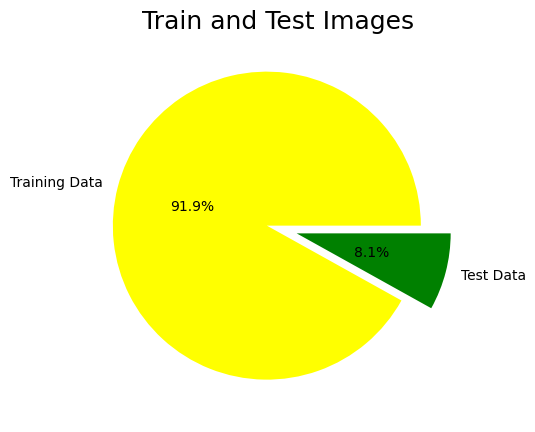

In [6]:
plt.figure(figsize=(8,5))
plt.pie(x = np.array([train,test]),autopct = '%.1f%%',explode = [0.1,0.1],labels = ['Training Data','Test Data'],pctdistance = 0.5,colors = ['yellow','green'])
plt.title('Train and Test Images ',fontsize = 18)

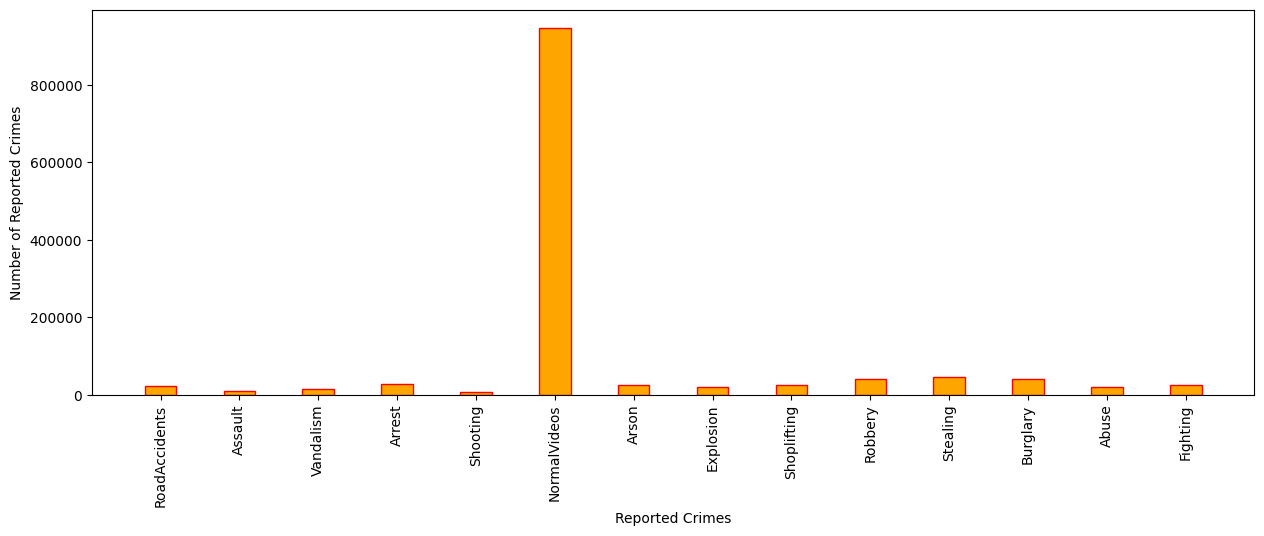

In [7]:
plt.figure(figsize = (15,5))
plt.bar(list(crimes.keys()),list(crimes.values()),width = 0.4,align = 'center',edgecolor = ['red'],color = ['orange'])
plt.xticks(rotation = 90)
plt.xlabel ('Reported Crimes')
plt.ylabel('Number of Reported Crimes')
plt.show()

In [8]:
train_set = image_dataset_from_directory(
    train_dir,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
    image_size = IMG_SHAPE,
    shuffle = True,
    seed = seed,
    validation_split = 0.2,
    subset = 'training',
)

Found 1266345 files belonging to 14 classes.
Using 1013076 files for training.


In [9]:
val_set = image_dataset_from_directory(
    train_dir,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
    image_size = IMG_SHAPE,
    shuffle = True,
    seed = seed,
    validation_split = 0.2,
    subset = 'validation',
)

Found 1266345 files belonging to 14 classes.
Using 253269 files for validation.


In [10]:
test_set = image_dataset_from_directory(
    test_dir,
    label_mode = 'categorical',
    class_names = None,
    batch_size = BATCH_SIZE,
    image_size = IMG_SHAPE,
    shuffle = False,
    seed = seed,
)

Found 111308 files belonging to 14 classes.


In [11]:
def transfer_learning():
    base_model = DenseNet121(include_top = False,input_shape = INPUT_SHAPE,weights = 'imagenet')
    thr = 149
    for layers in base_model.layers[:thr]:
        layers.trainable = False
    for layers in base_model.layers[thr:]:
        layers.trainable = False
    return base_model

In [12]:
def create_model():
    model = Sequential()
    base_model = transfer_learning()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256,activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512,activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024,activation = 'relu'))
    model.add(Dense(n,activation = 'softmax'))
    model.summary()
    return model


In [13]:
INPUT_SHAPE = (64, 64, 3)

In [14]:
model = create_model()
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0 

In [15]:
history = model.fit(x = train_set,validation_data = val_set,epochs = EPOCHS)

Epoch 1/5
7915/7915 [==============================] - 6215s 784ms/step - loss: 0.3455 - accuracy: 0.9045 - val_loss: 0.1231 - val_accuracy: 0.9663
Epoch 2/5
7915/7915 [==============================] - 6387s 807ms/step - loss: 0.1946 - accuracy: 0.9451 - val_loss: 0.0919 - val_accuracy: 0.9747
Epoch 3/5
7915/7915 [==============================] - 7073s 893ms/step - loss: 0.1666 - accuracy: 0.9543 - val_loss: 0.0768 - val_accuracy: 0.9800
Epoch 4/5
7915/7915 [==============================] - 5910s 746ms/step - loss: 0.1531 - accuracy: 0.9588 - val_loss: 0.0650 - val_accuracy: 0.9830
Epoch 5/5
7915/7915 [==============================] - 6041s 763ms/step - loss: 0.1455 - accuracy: 0.9619 - val_loss: 0.0590 - val_accuracy: 0.9841


In [16]:
model.save('crime.h5')

In [19]:
from tensorflow.keras.models import load_model;
model.load_weights('crime.h5')

In [20]:
y_true = np.array([])
for x,y in test_set:
    y_true = np.concatenate([y_true,np.argmax(y.numpy(),axis = -1)])

In [21]:
y_pred = model.predict(test_set)

870/870 [==============================] - 512s 586ms/step


In [22]:
y_pred

array([[5.34858964e-02, 8.17905068e-02, 1.13303356e-01, ...,
        3.39325843e-03, 5.06038815e-02, 3.26646492e-02],
       [4.80229631e-02, 6.56272098e-02, 9.64185968e-02, ...,
        9.86915734e-03, 5.44050485e-02, 4.11182232e-02],
       [1.63765985e-03, 9.76466015e-03, 5.75954793e-04, ...,
        8.54013194e-07, 1.30511716e-03, 1.84188422e-04],
       ...,
       [2.83310364e-05, 1.14862989e-04, 9.87437716e-07, ...,
        1.69052358e-03, 5.04608033e-05, 9.63910788e-05],
       [6.52824292e-06, 1.98543185e-05, 1.29173941e-07, ...,
        1.34885806e-04, 4.84640213e-06, 1.44758624e-05],
       [1.37865063e-04, 4.26485116e-04, 4.50010202e-06, ...,
        4.60094213e-03, 1.51002590e-04, 2.07189063e-04]], dtype=float32)

In [23]:
y_true

array([ 0.,  0.,  0., ..., 13., 13., 13.])

In [25]:
from tensorflow.keras.preprocessing import image
import numpy as np

In [27]:
# Testing 1
img = image.load_img('../input/ucf-crime-dataset/Test/RoadAccidents/RoadAccidents001_x264_0.png',target_size=(64,64)) # Reading image
x = image.img_to_array(img) # converting image into array
x = np.expand_dims(x,axis = 0) #expanding Dimensions
pred = np.argmax(model.predict(x)) # Predicting the higher probability index
op = ['Fighting','Arrest','Vandalism','Assault','Stealing','Arson','NormalVideos','Burglary','Explosion','Robbery','Abuse','Shooting','Shoplifting','RoadAccident']
op[pred] # List indexing with output

1/1 [==============================] - 2s 2s/step


'Burglary'

In [35]:
# Testing 2
img = image.load_img('../input/ucf-crime-dataset/Test/Shoplifting/Shoplifting001_x264_0.png',target_size=(64,64)) # Reading image
x = image.img_to_array(img) # converting image into array
x = np.expand_dims(x,axis = 0) #expanding Dimensions
pred = np.argmax(model.predict(x)) # Predicting the higher probability index
op = ['Fighting','Arrest','Vandalism','Assault','Stealing','Arson','NormalVideos','Burglary','Explosion','Robbery','Abuse','Shooting','Shoplifting','RoadAccident']
op[pred] # List indexing with output

1/1 [==============================] - 0s 39ms/step


'Burglary'

In [37]:
# Testing 3
img = image.load_img('../input/ucf-crime-dataset/Test/Explosion/Explosion002_x264_0.png',target_size=(64,64)) # Reading image
x = image.img_to_array(img) # converting image into array
x = np.expand_dims(x,axis = 0) #expanding Dimensions
pred = np.argmax(model.predict(x)) # Predicting the higher probability index
op = ['Fighting','Arrest','Vandalism','Assault','Stealing','Arson','NormalVideos','Burglary','Explosion','Robbery','Abuse','Shooting','Shoplifting','RoadAccident']
op[pred] # List indexing with output

1/1 [==============================] - 0s 40ms/step


'Burglary'

In [38]:
# Testing 4
img = image.load_img('../input/ucf-crime-dataset/Test/Burglary/Burglary005_x264_0.png',target_size=(64,64)) # Reading image
x = image.img_to_array(img) # converting image into array
x = np.expand_dims(x,axis = 0) #expanding Dimensions
pred = np.argmax(model.predict(x)) # Predicting the higher probability index
op = ['Fighting','Arrest','Vandalism','Assault','Stealing','Arson','NormalVideos','Burglary','Explosion','Robbery','Abuse','Shooting','Shoplifting','RoadAccident']
op[pred] # List indexing with output

1/1 [==============================] - 0s 43ms/step


'Burglary'

In [40]:
# Testing 5
img = image.load_img('/kaggle/input/ucf-crime-dataset/Test/Robbery/Robbery048_x264_1040.png',target_size=(64,64)) # Reading image
x = image.img_to_array(img) # converting image into array
x = np.expand_dims(x,axis = 0) #expanding Dimensions
pred = np.argmax(model.predict(x)) # Predicting the higher probability index
op = ['Fighting','Arrest','Vandalism','Assault','Stealing','Arson','NormalVideos','Burglary','Explosion','Robbery','Abuse','Shooting','Shoplifting','RoadAccident']
op[pred] # List indexing with output

1/1 [==============================] - 0s 41ms/step


'Burglary'

In [41]:
training_accuracy = history.history['accuracy'][-1]  # Replace 'accuracy' with the metric used during training
validation_accuracy = history.history['val_accuracy'][-1]  # Replace 'val_accuracy' with the validation metric

In [43]:
print("Model Summary")
print("-")
print("Accuracy")
print(f"Training Accuracy: {training_accuracy}")
print(f"Validation Accuracy: {validation_accuracy}")

Model Summary
-
Accuracy
Training Accuracy: 0.9619347453117371
Validation Accuracy: 0.9841433167457581
